# Unpaired GAN

Ref: https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson7-wgan.ipynb



In [1]:
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.vision.gan import *

In [23]:
path = untar_data(URLs.LSUN_BEDROOMS)

In [3]:
# path = Path("./gandata")
# path_color = path/'color'

In [28]:
def get_data(bs, size):
    return (GANItemList.from_folder(path, noise_sz=100)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

In [29]:
bs = 128
size = 64
data = get_data(bs, size)

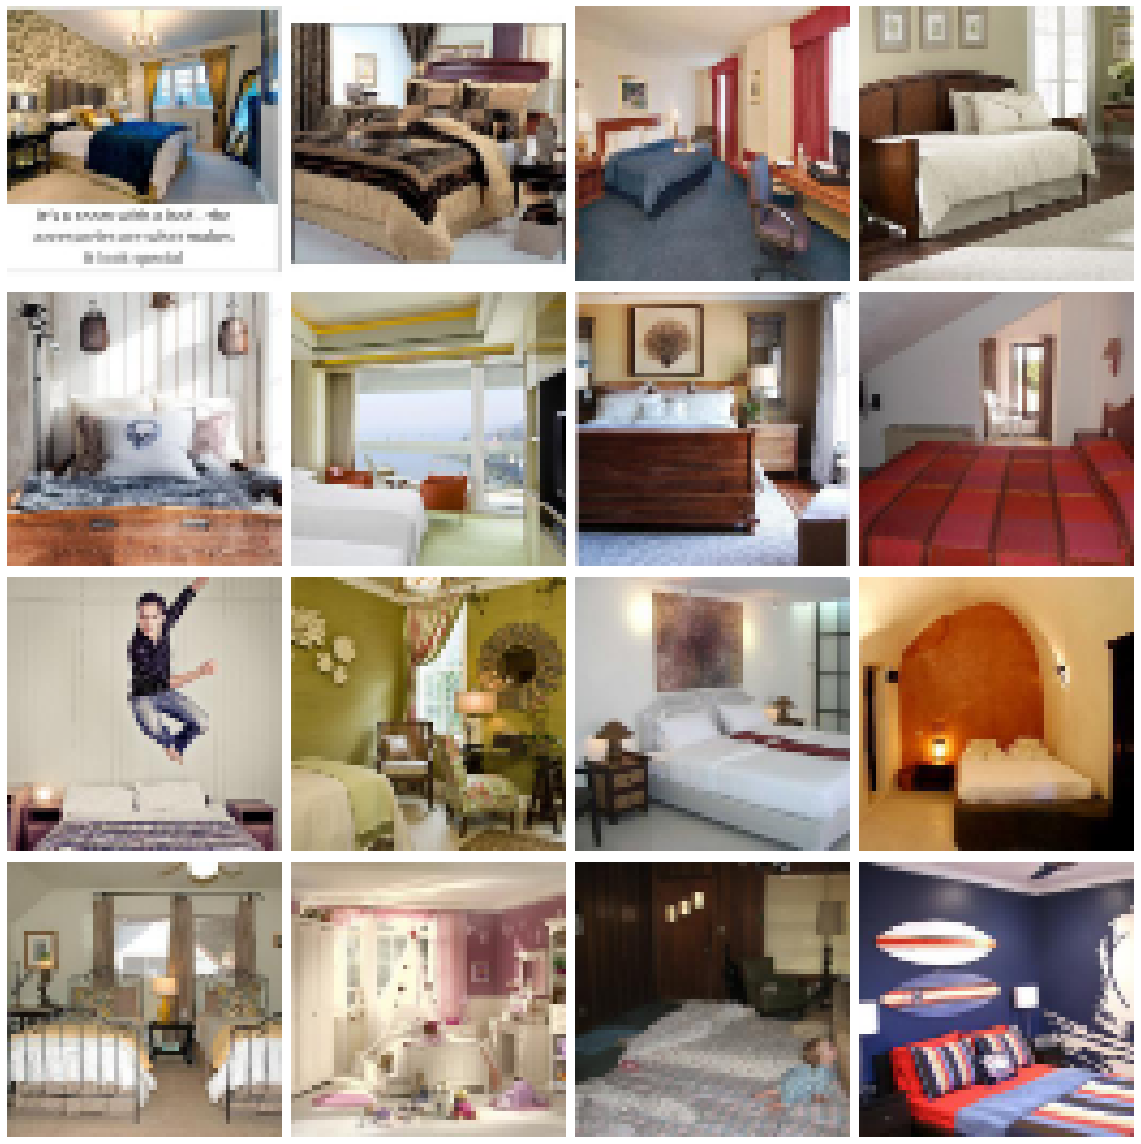

In [30]:
data.show_batch(rows=4)

# GAN models

GAN stands for Generative Adversarial Nets and were invented by Ian Goodfellow. The concept is that we will train two models at the same time: a generator and a critic. The generator will try to make new images similar to the ones in our dataset, and the critic will try to classify real images from the ones the generator does. The generator returns images, the critic a single number (usually 0. for fake images and 1. for real ones).

We train them against each other in the sense that at each step (more or less), we:

1. Freeze the generator and train the critic for one step by:
    - getting one batch of true images (let's call that real)
    - generating one batch of fake images (let's call that fake)
    - have the critic evaluate each batch and compute a loss function from that; the important part is that it rewards positively the detection of real images and penalizes the fake ones
    - update the weights of the critic with the gradients of this loss

2. Freeze the critic and train the generator for one step by:
    - generating one batch of fake images
    - evaluate the critic on it
    - return a loss that rewards posisitivly the critic thinking those are real images; the important part is that it rewards positively the detection of real images and penalizes the fake ones
    - update the weights of the generator with the gradients of this loss

Here, we'll use the Wassertein GAN.

In [ ]:
generator = basic_generator(in_size=64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (in_size=64, n_channels=3, n_extra_layers=1)

In [32]:
learn = GANLearner.wgan(data, generator, critic,
                        switch_eval=False,
                        opt_func=partial(optim.Adam, betas=(0., 0.99)),
                        wd=0.
                        )

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-0.598568,#na#,0.523040,-0.803064,03:54
1,-0.804383,#na#,0.544546,-1.074833,03:46
2,-0.749648,#na#,0.528124,-1.017611,03:46
3,-0.667067,#na#,0.493503,-0.902907,03:45
4,-0.588297,#na#,0.428978,-0.792570,03:45
5,-0.538394,#na#,0.424910,-0.742961,03:46
6,-0.549815,#na#,0.384603,-0.725057,03:46
7,-0.532125,#na#,0.381386,-0.719901,03:47
8,-0.504974,#na#,0.376658,-0.696594,03:47
9,-0.481725,#na#,0.345126,-0.638375,03:48


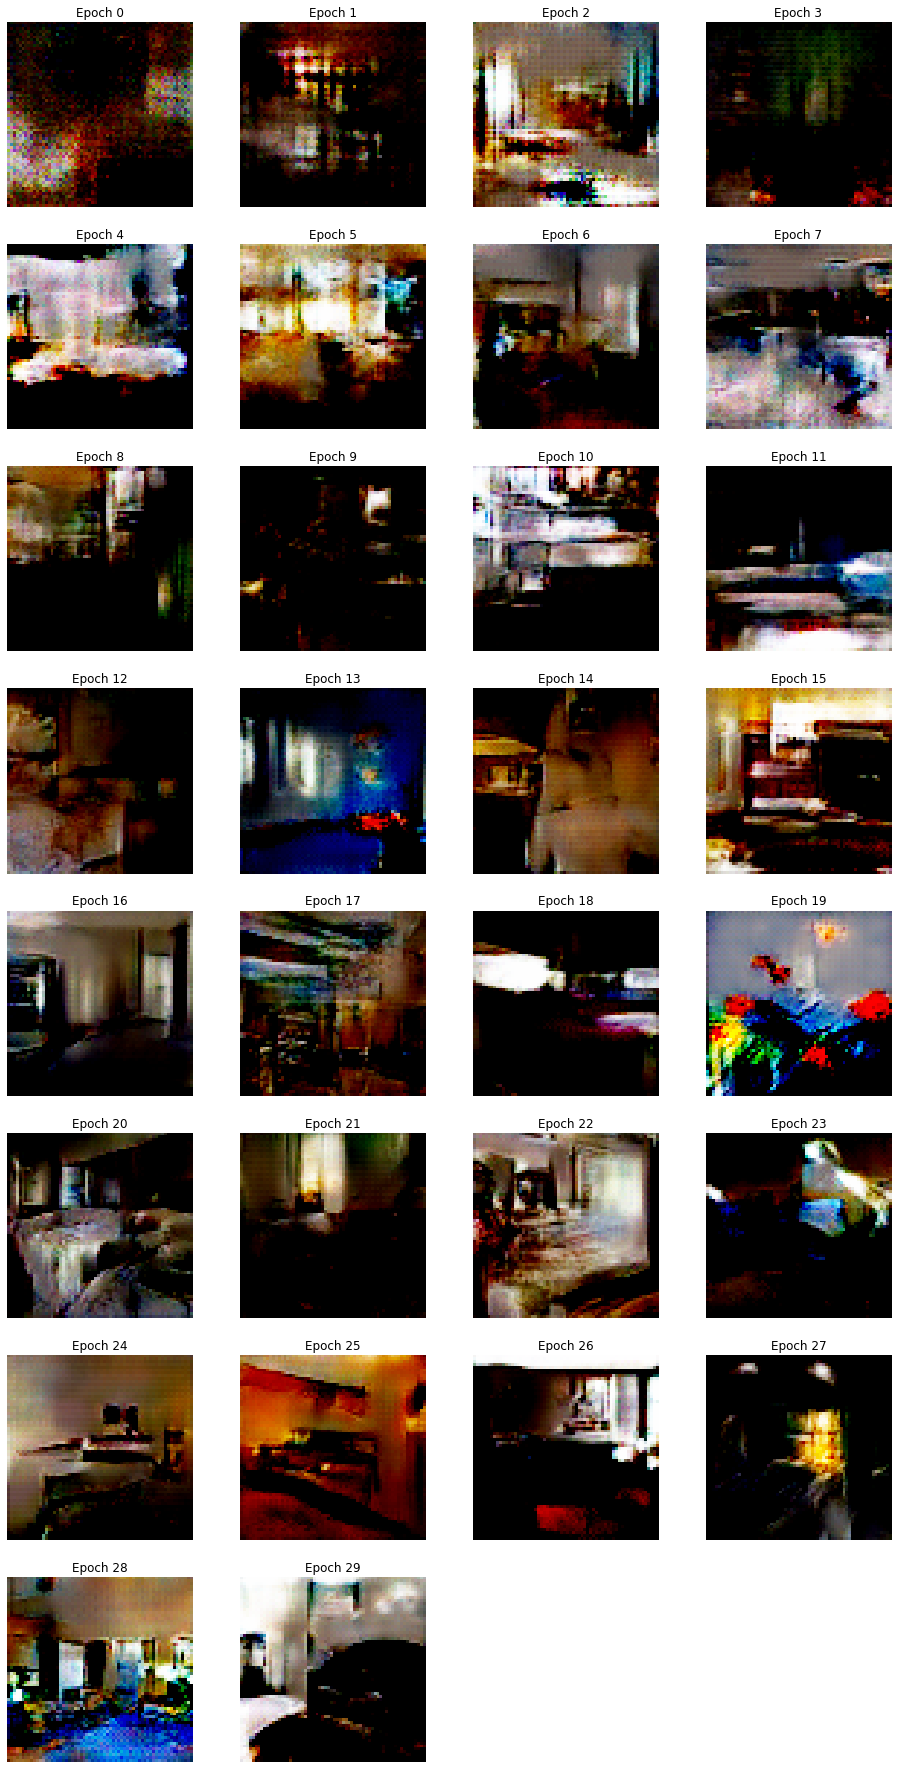

In [33]:
learn.fit(30, 2e-4)

In [34]:
learn.save("bedroon-gan")

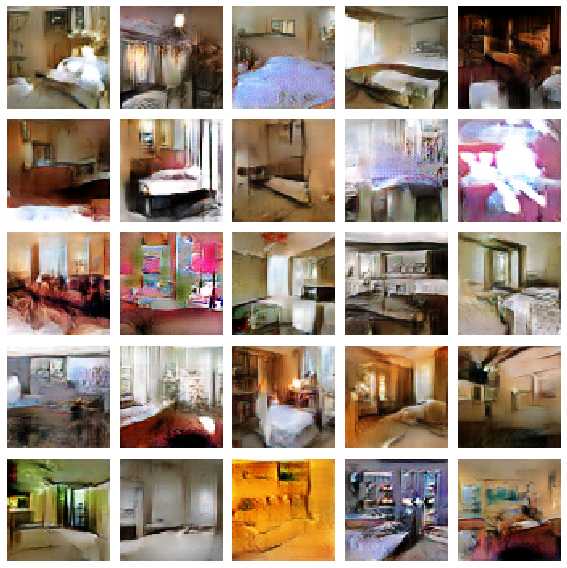

In [35]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=5, figsize=(8,8))